In [ ]:
import requests
import pandas as pd
import selenium
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import random
import re
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# FUNCIONES

In [153]:
def accept_cookies(driver):
    """Función para aceptar cookies en la página web."""
    time.sleep(random.uniform(5, 10))  # Esperar a que la página cargue
    try:
        agree_button = driver.find_element(By.ID, "didomi-notice-agree-button")
        agree_button.click()
        print("Se hizo clic en el botón de aceptar cookies")
    except Exception as e:
        print(f"No se encontró el botón de aceptar cookies")
    time.sleep(random.uniform(0.5, 1))  # Esperar después de hacer clic

def extraer_info_descripcion(df):
    def detectar_motor(desc):
        desc = desc.lower()
        # Buscar 3.0i, 2.8i, etc.
        match = re.search(r'\b(\d\.\d)i\b', desc)
        if match:
            return match.group(1)
        
        # Buscar 2000 cc / 2000cc
        match = re.search(r'(\d{4})\s?cc', desc)
        if match:
            cc = int(match.group(1))
            if 1000 <= cc <= 6000:
                return f"{cc/1000:.1f}"

        # Buscar 2.0, 2,0 (coma como separador decimal)
        match = re.search(r'\b(\d[\.,]\d)\b', desc)
        if match:
            return match.group(1).replace(',', '.')

        # Buscar 2l o 2 litros
        match = re.search(r'\b([1-6](?:[\.,]\d)?)\s?(l|litros)\b(?!/\d{2,3})', desc)
        if match:
            return match.group(1)

        return None

    def detectar_modelo(desc):
        desc = desc.lower()
        if 'roadster' in desc:
            return 'ROADSTER'
        elif 'coupe' in desc or 'coupé' in desc:
            return 'COUPE'
        elif 'cabrio' in desc:
            return 'ROADSTER'  # Asumimos que cabrio = roadster
        return None

    # Extraer motor
    df['motor_from_desc'] = df['description'].apply(detectar_motor)

    # Extraer tipo de carrocería
    df['carroceria_from_desc'] = df['description'].apply(detectar_modelo)

    # Combinar motor y carrocería en formato '2.0 ROADSTER'
    def construir_version(motor, carroceria):
        if pd.notna(motor) and pd.notna(carroceria):
            return f"{motor} {carroceria}".upper()
        elif pd.notna(motor):
            return str(motor).upper()
        elif pd.notna(carroceria):
            return str(carroceria).upper()
        return None
 

    df['version_from_desc'] = df.apply(
        lambda row: construir_version(row['motor_from_desc'], row['carroceria_from_desc']),
        axis=1
    )
    
    df.drop(columns=['carroceria_from_desc'], inplace=True)

    return df

def data_preprocessing(df):
    df = df.drop_duplicates()

    # Establecer marca y modelo fijos
    df['brand'] = 'BMW'
    df['model'] = 'Z3'

    # Expresiones regulares para extraer motor y tipo de carrocería
    def extract_info(name):
        name = name.upper()

        # Extraer el motor (ej: 3.0i, 2.2, etc.)
        engine_match = re.search(r'(\d\.\d)(I)?', name)
        engine = engine_match.group(1) if engine_match else None

        # Identificar si es 'COUPE' o 'ROADSTER' (u otro)
        if 'COUPE' in name:
            body = 'COUPE'
        elif 'ROADSTER' in name:
            body = 'ROADSTER'
        else:
            body = ''

        # Formar la versión estandarizada
        version = f"{engine} {body}".strip() if engine else body

        return pd.Series([engine, version])

    # Limpiar kms: "100.000 km" → 100000
    df['kms'] = df['kms'].str.replace('.', '', regex=False).str.extract(r'(\d+)').astype(float)

    # Limpiar cv: "150 cv" → 150
    df['cv'] = df['cv'].str.extract(r'(\d+)').astype(float)

    # Limpiar price: "12.950 €" → 12950
    df['price'] = df['price'].str.replace('.', '', regex=False).str.extract(r'(\d+)').astype(float)

    df[['engine', 'version']] = df['name'].apply(extract_info)

    return df

def actualizar_con_descripciones(df_main, df_extra):
    # Unir los dos DataFrames por 'url'
    merged = pd.merge(df_main, df_extra, on='url', how='left')

    # Actualizar columnas solo si en df_extra hay datos
    for col_main, col_extra in [
        ('engine', 'motor_from_desc'),
        ('cv', 'cv_from_desc'),
        ('version', 'version_from_desc'),
    ]:
        merged[col_main] = merged[col_extra].combine_first(merged[col_main])

    # Eliminar columnas extra que no necesitas
    merged = merged[df_main.columns]
    merged['year'] = merged['year'].astype(int)
    merged['kms'] = merged['kms'].astype(float).astype(int)
    merged['cv'] = pd.to_numeric(merged['cv'], errors='coerce').astype('Int64')
    return merged



def regression_data_processing(df, engine_cc_filter, var='kms'):
    """
    Filtra y limpia datos, ajusta el modelo y añade columnas:
    predicted_price
    """
    filtered_df = df[df['engine'] == engine_cc_filter].copy()
    filtered_df = filtered_df.dropna(subset=[var])
    # Modelo regresión lineal
    X = filtered_df[[var]].values
    y = filtered_df['price'].values
    model = LinearRegression()
    model.fit(X, y)
    filtered_df['predicted_price'] = model.predict(X)

    return filtered_df, model

# Estrategias (reciben DataFrame con predicted_price ya calculado)

def strategy_discount_line(df, discount_factor=0.85):
    df = df.copy()
    df['discount_line'] = df['predicted_price'] * discount_factor
    return df['price'] < df['discount_line']

def strategy_residual_threshold(df, threshold_euros=1000):
    df = df.copy()
    df['residual'] = df['predicted_price'] - df['price']
    return df['residual'] > threshold_euros

def strategy_top_percentile_residuals(df, percentile=90):
    df = df.copy()
    df['residual'] = df['predicted_price'] - df['price']
    threshold = np.percentile(df['residual'], percentile)
    return df['residual'] > threshold

def strategy_residual_zscore(df, z_threshold=1.5):
    df = df.copy()
    df['residual'] = df['predicted_price'] - df['price']
    z_mean = df['residual'].mean()
    z_std = df['residual'].std()
    df['z_score'] = (df['residual'] - z_mean) / z_std
    return df['z_score'] > z_threshold

def plot_strategy_separately(df, model, var='kms', discount_factor=0.85, strategy_mask=None, strategy_name="Estrategia"):
    """
    Grafica los datos diferenciando con color rojo los coches que cumplen la estrategia dada.
    - df: DataFrame con columnas kms, price, predicted_price
    - model: modelo de regresión entrenado
    - discount_factor: para graficar la línea de descuento
    - strategy_mask: máscara booleana indicando coches que cumplen la estrategia
    - strategy_name: nombre para leyenda y título
    """
    X_range = np.linspace(df[var].min(), df[var].max(), 100).reshape(-1, 1)
    y_pred = model.predict(X_range)
    y_discount = y_pred * discount_factor

    plt.figure(figsize=(10,6))
    # Puntos que no cumplen la estrategia
    plt.scatter(df.loc[~strategy_mask, var], df.loc[~strategy_mask, 'price'],
                alpha=0.5, label='Datos')
    # Puntos que cumplen la estrategia
    plt.scatter(df.loc[strategy_mask, var], df.loc[strategy_mask, 'price'],
                color='red', label='Buena oferta')

    plt.plot(X_range, y_pred, color='blue', label='Regresión lineal')
    plt.plot(X_range, y_discount, color='green', linestyle='--',
             label=f'Oferta (~{int((1 - discount_factor)*100)}% menos)')

    plt.xlabel('Kilómetros')
    plt.ylabel('Precio (€)')
    plt.title(f'Relación Km vs Precio - {strategy_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# SCRAPPING COCHES.NET

In [36]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import random
# Cambiar el user-agent para simular un navegador real
# El user-agent que tienes es de Chrome 114, pero tu Chrome es versión 137.
# Puedes actualizar el user-agent para que coincida con tu versión real de Chrome:


# Inicializar el navegador con undetected_chromedriver
# Ya estás usando undetected_chromedriver, que ayuda a evitar la detección.
# Además, puedes agregar opciones para hacer el navegador más "humano":

# options = uc.ChromeOptions()
# options.add_argument("--disable-blink-features=AutomationControlled")
# options.add_argument("--no-sandbox")
# options.add_argument("--disable-infobars")
# options.add_argument("--disable-extensions")
# options.add_argument("--profile-directory=Default")
# options.add_argument("--disable-plugins-discovery")
# options.add_argument("--start-maximized")
# options.add_argument("--disable-dev-shm-usage")
# user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.7151.120 Safari/537.36"
# options.add_argument(f"user-agent={user_agent}")

# Desactivar la automatización de Selenium en el navegador
# options.add_experimental_option("excludeSwitches", ["enable-automation"])
# options.add_experimental_option("useAutomationExtension", False)
# options.add_argument("user_agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36")

driver = uc.Chrome()  # options=options
base_url = "https://www.coches.net/search/?MakeIds%5B0%5D=7&ModelIds%5B0%5D=282&Versions%5B0%5D=&pg="
df = pd.DataFrame(columns=["name", "price", "fuel_type", "year", "kms", "cv", "location", "url"])

page = 1  # Iniciar desde la página 1
while True:
    try:
        # Construir la URL de la página actual
        url = f"{base_url}{page}"
        driver.get(url)
        print(f"Cargando página {page}...")

        # Esperar a que la página cargue completamente
        time.sleep(random.uniform(5, 10))

        # Buscar el botón de aceptar cookies solo en la primera página
        if page == 1:
            try:
                agree_button = driver.find_element(By.ID, "didomi-notice-agree-button")
                agree_button.click()
                print("Se hizo clic en el botón de aceptar cookies")
            except Exception as e:
                print(f"No se encontró el botón de aceptar cookies: {e}")

        # Desplazar hasta el fondo de la página para cargar más contenido
        scroll_increment = 400
        last_height = driver.execute_script("return document.body.scrollHeight")
        current_position = 0
        while current_position < last_height:
            driver.execute_script(f"window.scrollTo(0, {current_position});")
            time.sleep(random.uniform(1, 1.2))
            current_position += scroll_increment
            last_height = driver.execute_script("return document.body.scrollHeight")
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(random.uniform(2, 5))

        # Obtener los anuncios de la página actual
        car_ads = driver.find_elements(By.CLASS_NAME, "mt-CardAd-infoContainer")
        if not car_ads:
            print("No se encontraron más anuncios. Finalizando...")
            break

        for add in car_ads:
            try:
                # Buscar los elementos dentro de cada anuncio
                name = add.find_element(By.CLASS_NAME, "mt-CardAd-infoHeaderTitleLink").text
                price = add.find_element(By.CLASS_NAME, "mt-CardAdPrice-cashAmount").text
                attributes = add.find_elements(By.CLASS_NAME, "mt-CardAd-attrItem")

                # Obtener todos los atributos de la lista
                # Inicializar valores
                fuel_type, year, kms, cv, location = "N/A", "N/A", "N/A", "N/A", "N/A"

                # Recorrer los atributos y asignar según contenido
                for attr in attributes:
                    text = attr.text.strip()

                    if text.lower() in ["gasolina", "diésel", "eléctrico", "híbrido", "hibrido", "glp", "gnc"]:
                        fuel_type = text
                    elif "km" in text.lower():
                        kms = text
                    elif "cv" in text.lower():
                        cv = text
                    elif text.isdigit() and len(text) == 4:
                        year = text
                    else:
                        location = text  # suele ir al final si no es otra cosa
                url = add.find_element(By.CLASS_NAME, "mt-CardAd-infoHeaderTitleLink").get_attribute("href")
                # Agregar los datos al DataFrame
                df = pd.concat([df, pd.DataFrame([{
                    "name": name,
                    "price": price,
                    "fuel_type": fuel_type,
                    "year": year,
                    "kms": kms,
                    "cv": cv,
                    "location": location,
                    "url": url,
                }])], ignore_index=True)
            except Exception as e:
                print(f"Error al procesar un anuncio: {e}")

        # Incrementar el número de página
        page += 1

    except Exception as e:
        print(f"Error al cargar la página {page}: {e}")
        break

# Cerrar el navegador
print("Cerrando el navegador")
driver.quit()

Cargando página 1...
Se hizo clic en el botón de aceptar cookies
Cargando página 2...
Cargando página 3...
Cargando página 4...
Cargando página 5...
No se encontraron más anuncios. Finalizando...
Cerrando el navegador


# SCRAPED DATA PREPROCESSING

In [154]:
df_test = data_preprocessing(df)
df_test

C:\Users\nicov\AppData\Local\Temp\ipykernel_10540\509756637.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['brand'] = 'BMW'
C:\Users\nicov\AppData\Local\Temp\ipykernel_10540\509756637.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = 'Z3'
C:\Users\nicov\AppData\Local\Temp\ipykernel_10540\509756637.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,name,price,fuel_type,year,kms,cv,location,url,brand,model,engine,version
0,BMW Z3 2.0 ROADSTER,12999.0,Gasolina,2000,84000.0,150.0,Alicante,https://www.coches.net/bmw-z3-20-roadster-2p-g...,BMW,Z3,2.0,2.0 ROADSTER
1,BMW Z3 1.9I,13900.0,Gasolina,1996,110000.0,140.0,Valencia,https://www.coches.net/bmw-z3-19i-2p-gasolina-...,BMW,Z3,1.9,1.9
2,BMW Z3 1.9i Roadster,12950.0,Gasolina,2001,100000.0,118.0,Madrid,https://www.coches.net/bmw-z3-19i-roadster-2p-...,BMW,Z3,1.9,1.9 ROADSTER
5,BMW Z3 1.8I,8999.0,Gasolina,1998,132288.0,115.0,Castellón,https://www.coches.net/bmw-z3-1.8i-2p-gasolina...,BMW,Z3,1.8,1.8
7,BMW Z3 1.9I,10000.0,Gasolina,1997,197000.0,140.0,Alicante,https://www.coches.net/bmw-z3-19i-2p-gasolina-...,BMW,Z3,1.9,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...
109,BMW Z3 2.2i Roadster,18000.0,Gasolina,2002,92000.0,170.0,Córdoba,https://www.coches.net/bmw-z3-22i-roadster-2p-...,BMW,Z3,2.2,2.2 ROADSTER
110,BMW Z3 3.0i Coupe,27990.0,Gasolina,2000,253125.0,231.0,Valencia,https://www.coches.net/bmw-z3-3.0i-coupe-2p-ga...,BMW,Z3,3.0,3.0 COUPE
111,BMW Z3,8500.0,Gasolina,1998,194500.0,NaN,Tarragona,https://www.coches.net/bmw-z3-gasolina-1998-en...,BMW,Z3,None,
112,BMW Z3 1.9I,11990.0,Gasolina,1997,91000.0,140.0,Sta. C. Tenerife,https://www.coches.net/bmw-z3-1.9i-2p-gasolina...,BMW,Z3,1.9,1.9


In [ ]:
# df_test.to_csv("cochesnet_z3_raw.csv", index=False)

In [33]:
len(df_test[df_test['version'] == ''])


40

# SCRAPPING MISSING DATA

In [ ]:
import pandas as pd
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import random

# Filtrar los registros de df_test donde 'modelo' == 'Z3'
filtered_records = df_test[df_test['version'] == '']

# Inicializar el navegador
driver = uc.Chrome()

# Crear un DataFrame para almacenar los resultados del scraping
df_model_details = pd.DataFrame(columns=["url", "description"])

try:
    for index, row in filtered_records.iterrows():
        try:
            # Obtener la URL del registro
            url = row['url']
            print(f"Scraping URL: {url}")

            # Navegar a la URL
            driver.get(url)
            # Comprobar si hay un captcha y esperar a que el usuario lo resuelva manualmente
            try:
                captcha_element = driver.find_element(By.CLASS_NAME, "h-captcha")
                if captcha_element.is_displayed():
                    input("Hay captcha, resuélvelo manualmente y pulsa Enter para continuar...")
            except Exception:
                pass  # No hay captcha, continuar normalmente
            accept_cookies(driver)
            # time.sleep(100)  # Esperar a que la página cargue completamente

            # Extraer la descripción del modelo (ajusta el selector según la estructura de la página)
            description_element = driver.find_element(By.CLASS_NAME, "mt-PanelAdDetails-commentsContent")  # Cambia "description-class-name" al selector correcto
            description = description_element.text
            # print(f"Descripción extraída: {description}")
            # Agregar los datos al DataFrame
            df_model_details = pd.concat([df_model_details, pd.DataFrame([{
                "url": url,
                "description": description
            }])], ignore_index=True)

        except Exception as e:
            print(f"Error al procesar la URL {url}: {e}")

finally:
    # Cerrar el navegador
    print("Cerrando el navegador")
    driver.quit()

# Mostrar los resultados
print(df_model_details)

In [ ]:

df_model_details = extraer_info_descripcion(df_model_details)
# df_model_details.drop(columns=['modelo_from_desc'], inplace=True)
# df_model_details

,url,description,motor_from_desc,cv_from_desc,version_from_desc
0,https://www.coches.net/bmw-z3-gasolina-1997-en...,Se vende o se cambia bmw z3 en muy buen estado...,None,NaN,None
1,https://www.coches.net/bmw-z3-gasolina-1998-en...,"BMW z3 .2.8 192cv, automático ITV recién pasad...",2.8,192,2.8 COUPE
2,https://www.coches.net/bmw-z3-gasolina-1999-en...,"Vehículo en buen estado a pesar de sus años, e...",None,NaN,None
3,https://www.coches.net/bmw-z3-gasolina-2000-en...,Right Hand Drive. Volante a la derecha. Capota...,None,NaN,None
4,https://www.coches.net/bmw-z3-gasolina-1996-en...,Bmw z3 cabrio del 96\n*Un gran clásico del mun...,1.8,115,1.8 ROADSTER
5,https://www.coches.net/bmw-z3-gasolina-1997-en...,Perfecto estado por fuera y por dentro,None,NaN,None
6,https://www.coches.net/bmw-z3-gasolina-2000-en...,"En perfecto estado, en córdoba,capota eléctric...",None,NaN,None
7,https://www.coches.net/bmw-z3-gasolina-1998-en...,Mmw z3 cabrio tiene 2 capotas la de lona y el ...,None,NaN,ROADSTER
8,https://www.coches.net/bmw-z3-gasolina-2003-en...,BMW z3 1.9 roadster. Nacional. Mejor ver. Lanz...,1.9,NaN,1.9 ROADSTER
9,https://www.coches.net/bmw-z3-gasolina-2003-en...,"ITV Reciente , perfecto estado .",None,NaN,None


In [158]:
df_infered = actualizar_con_descripciones(df_test, df_model_details)
df_infered['engine'] = df_infered.engine.fillna('NA')
df_infered['version'] = df_infered['version'].replace('', 'NA')
df_infered.to_csv("cochesnet_z3.csv", index=False)  
df_infered

,name,price,fuel_type,year,kms,cv,location,url,brand,model,engine,version
0,BMW Z3 2.0 ROADSTER,12999.0,Gasolina,2000,84000,150,Alicante,https://www.coches.net/bmw-z3-20-roadster-2p-g...,BMW,Z3,2.0,2.0 ROADSTER
1,BMW Z3 1.9I,13900.0,Gasolina,1996,110000,140,Valencia,https://www.coches.net/bmw-z3-19i-2p-gasolina-...,BMW,Z3,1.9,1.9
2,BMW Z3 1.9i Roadster,12950.0,Gasolina,2001,100000,118,Madrid,https://www.coches.net/bmw-z3-19i-roadster-2p-...,BMW,Z3,1.9,1.9 ROADSTER
3,BMW Z3 1.8I,8999.0,Gasolina,1998,132288,115,Castellón,https://www.coches.net/bmw-z3-1.8i-2p-gasolina...,BMW,Z3,1.8,1.8
4,BMW Z3 1.9I,10000.0,Gasolina,1997,197000,140,Alicante,https://www.coches.net/bmw-z3-19i-2p-gasolina-...,BMW,Z3,1.9,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...
106,BMW Z3 2.2i Roadster,18000.0,Gasolina,2002,92000,170,Córdoba,https://www.coches.net/bmw-z3-22i-roadster-2p-...,BMW,Z3,2.2,2.2 ROADSTER
107,BMW Z3 3.0i Coupe,27990.0,Gasolina,2000,253125,231,Valencia,https://www.coches.net/bmw-z3-3.0i-coupe-2p-ga...,BMW,Z3,3.0,3.0 COUPE
108,BMW Z3,8500.0,Gasolina,1998,194500,<NA>,Tarragona,https://www.coches.net/bmw-z3-gasolina-1998-en...,BMW,Z3,NA,NA
109,BMW Z3 1.9I,11990.0,Gasolina,1997,91000,140,Sta. C. Tenerife,https://www.coches.net/bmw-z3-1.9i-2p-gasolina...,BMW,Z3,1.9,1.9


In [ ]:
len(df_infered[df_infered['version'] == 'NA'])

22

# VISUALIZACION

In [160]:
df_infered = pd.read_csv("cochesnet_z3.csv", dtype={'year': 'Int64', 'kms': 'Int64', 'cv': 'Int64', 'engine': 'str'})
df_infered

,name,price,fuel_type,year,kms,cv,location,url,brand,model,engine,version
0,BMW Z3 2.0 ROADSTER,12999.0,Gasolina,2000,84000,150,Alicante,https://www.coches.net/bmw-z3-20-roadster-2p-g...,BMW,Z3,2.0,2.0 ROADSTER
1,BMW Z3 1.9I,13900.0,Gasolina,1996,110000,140,Valencia,https://www.coches.net/bmw-z3-19i-2p-gasolina-...,BMW,Z3,1.9,1.9
2,BMW Z3 1.9i Roadster,12950.0,Gasolina,2001,100000,118,Madrid,https://www.coches.net/bmw-z3-19i-roadster-2p-...,BMW,Z3,1.9,1.9 ROADSTER
3,BMW Z3 1.8I,8999.0,Gasolina,1998,132288,115,Castellón,https://www.coches.net/bmw-z3-1.8i-2p-gasolina...,BMW,Z3,1.8,1.8
4,BMW Z3 1.9I,10000.0,Gasolina,1997,197000,140,Alicante,https://www.coches.net/bmw-z3-19i-2p-gasolina-...,BMW,Z3,1.9,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...
106,BMW Z3 2.2i Roadster,18000.0,Gasolina,2002,92000,170,Córdoba,https://www.coches.net/bmw-z3-22i-roadster-2p-...,BMW,Z3,2.2,2.2 ROADSTER
107,BMW Z3 3.0i Coupe,27990.0,Gasolina,2000,253125,231,Valencia,https://www.coches.net/bmw-z3-3.0i-coupe-2p-ga...,BMW,Z3,3.0,3.0 COUPE
108,BMW Z3,8500.0,Gasolina,1998,194500,<NA>,Tarragona,https://www.coches.net/bmw-z3-gasolina-1998-en...,BMW,Z3,NaN,NaN
109,BMW Z3 1.9I,11990.0,Gasolina,1997,91000,140,Sta. C. Tenerife,https://www.coches.net/bmw-z3-1.9i-2p-gasolina...,BMW,Z3,1.9,1.9


In [145]:
df_infered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       111 non-null    object 
 1   price      111 non-null    float64
 2   fuel_type  111 non-null    object 
 3   year       111 non-null    Int64  
 4   kms        111 non-null    Int64  
 5   cv         79 non-null     Int64  
 6   location   110 non-null    object 
 7   url        111 non-null    object 
 8   brand      111 non-null    object 
 9   model      111 non-null    object 
 10  engine     85 non-null     object 
 11  version    89 non-null     object 
dtypes: Int64(3), float64(1), object(8)
memory usage: 10.9+ KB


In [ ]:
# df_infered.version.fillna('NA', inplace=True)
# df_infered.to_csv("cochesnet_z3.csv", index=False)

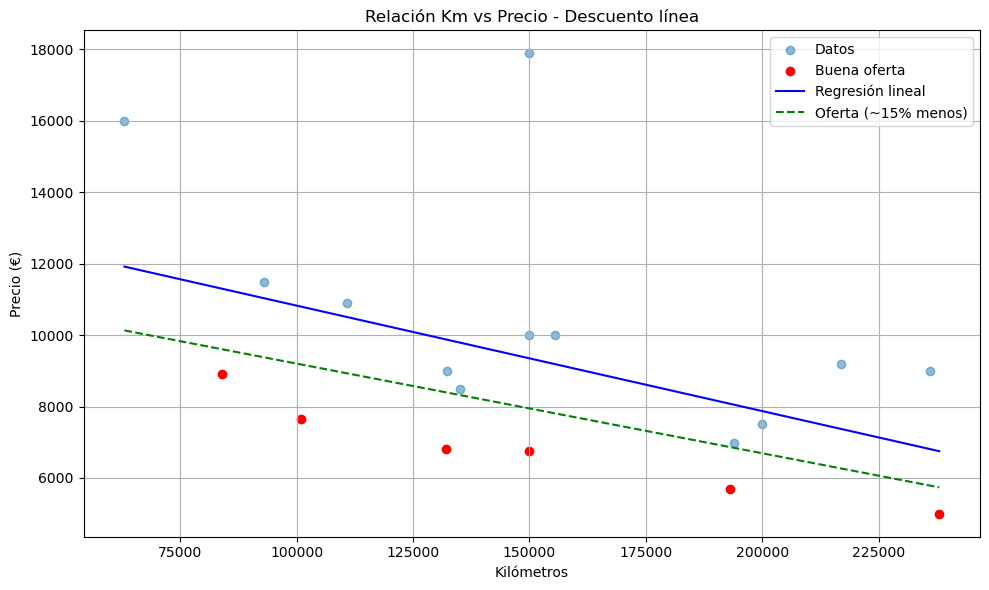

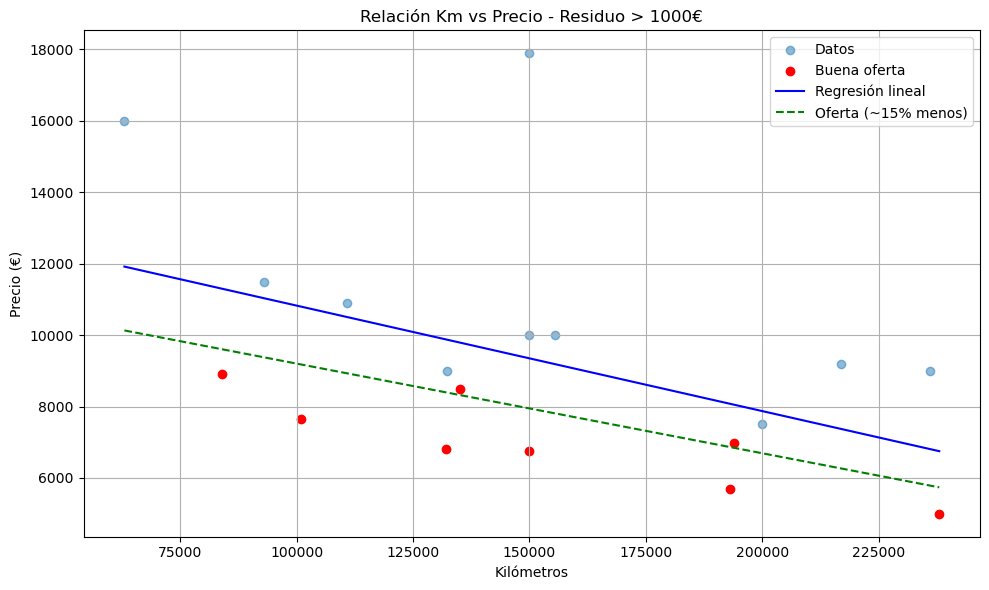

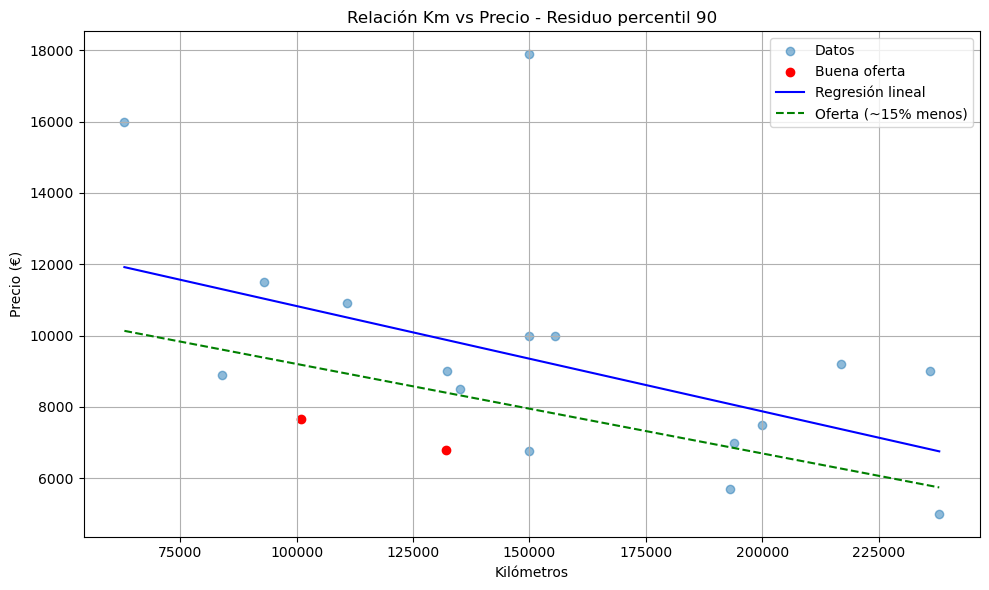

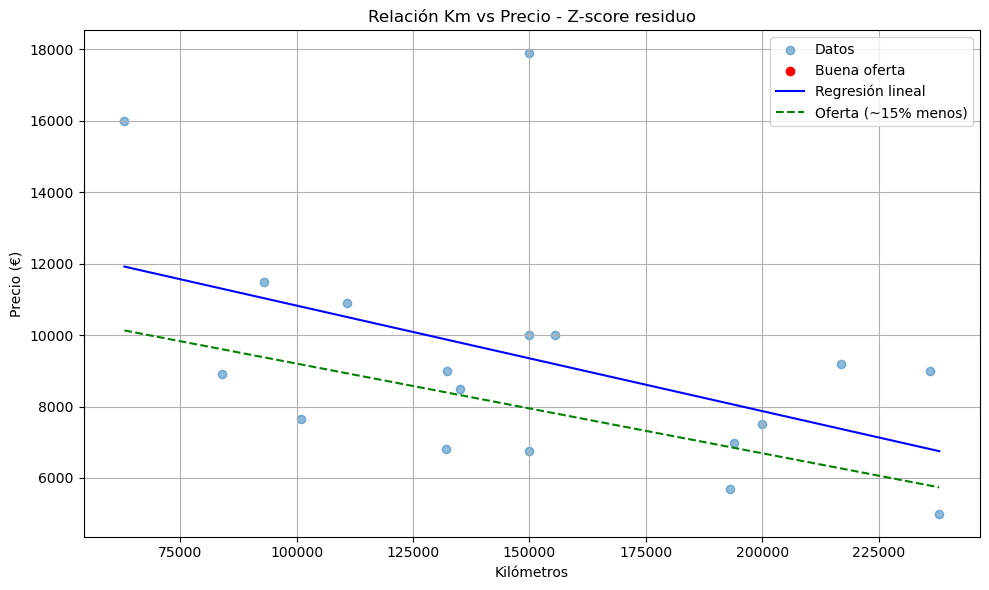

In [126]:
var = 'kms'  # Cambia esto a 'kms' o 'cv' según lo que quieras analiza
df_filtered, model = regression_data_processing(df_infered, '1.8', var=var)

strategies = {
    'Descuento línea': strategy_discount_line(df_filtered, 0.85),
    'Residuo > 1000€': strategy_residual_threshold(df_filtered, 1000),
    'Residuo percentil 90': strategy_top_percentile_residuals(df_filtered, 90),
    'Z-score residuo': strategy_residual_zscore(df_filtered, 1.5)
}

for name, mask in strategies.items():
    plot_strategy_separately(df_filtered, model, var=var, discount_factor=0.85, strategy_mask=mask, strategy_name=name)



In [131]:
df_infered['engine'].unique()

array(['2.0', '1.9', '1.8', nan, '2.8', '3.0', '3.2', '2.2'], dtype=object)